In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import nltk
from sklearn.feature_extraction import DictVectorizer


In [2]:
CPU = torch.device('cpu')
GPU = torch.device('cuda')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    if isinstance(data, dict):
        return dict((k, to_device(v, device)) for k, v in data.items())
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
anime_initial = pd.read_csv('./anime.csv')
ratings_initial = pd.read_csv('./rating.csv')

In [31]:
anime_initial = anime_initial.head(int(len(anime_initial) * 0.5))
ratings_initial = ratings_initial.head(int(len(ratings_initial) * 0.1))

# Предварительная обработка

In [32]:
anime_ids = set(anime_initial['anime_id'].values)
rating_to_remove = [i for i, a_id in enumerate(ratings_initial['anime_id']) if a_id not in anime_ids]
print(f'{len(rating_to_remove)} animes from rating.csv are not present in anime.csv ({len(rating_to_remove) / len(ratings_initial) * 100:.3}% from all)')

26369 animes from rating.csv are not present in anime.csv (3.37% from all)


In [33]:
anime_ids = set(ratings_initial['anime_id'].values)
anime_to_remove = [i for i, a_id in enumerate(anime_initial['anime_id']) if a_id not in anime_ids]
print(f'{len(anime_to_remove)} animes from anime.csv are not present in rating.csv ({len(anime_to_remove) / len(anime_initial) * 100:.3}% from all)')

525 animes from anime.csv are not present in rating.csv (8.54% from all)


In [34]:
# remove records that are not present in both tables
ratings = ratings_initial.copy().drop(rating_to_remove).reset_index(drop=True)
anime = anime_initial.copy().drop(anime_to_remove).reset_index(drop=True)

In [35]:
# map from old to new ids
new_ids = dict((v, k) for k, v in dict([*enumerate(anime['anime_id'])]).items())

In [36]:
# rewrite anime_id values
ratings['anime_id'] = ratings['anime_id'].apply(new_ids.get)
anime['anime_id'] = anime['anime_id'].apply(new_ids.get)

Создаем матрицу X. Строки - юзеры, столбцы - аниме, на пересечении - оценка

In [37]:
USERS_NUM = ratings['user_id'].values.max()
ANIME_NUM = len(anime)
X = np.zeros((USERS_NUM, ANIME_NUM), np.int8)

for r in ratings.values:
    X[r[0]-1][r[1]] = r[2]

### Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий

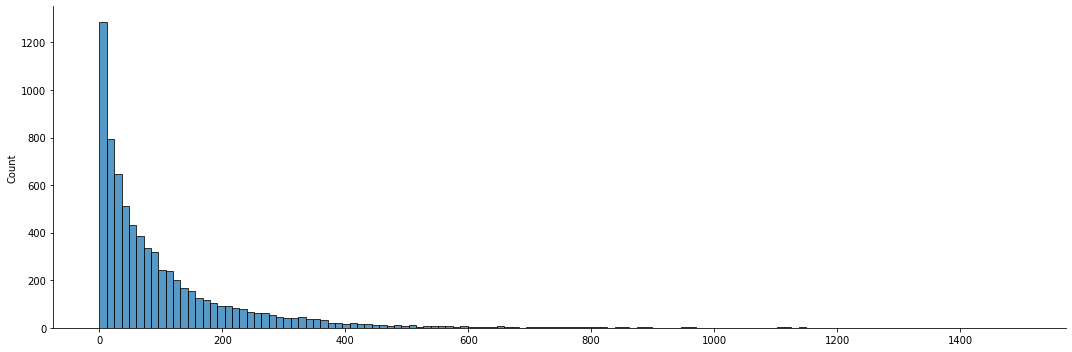

In [90]:
interactions = np.zeros(USERS_NUM)
for i, x in enumerate(X):
    interactions[i] += np.count_nonzero(x)

sns.displot(data=interactions, aspect=3)

* Разпределение числа "айтемов" по количеству взаимодействий

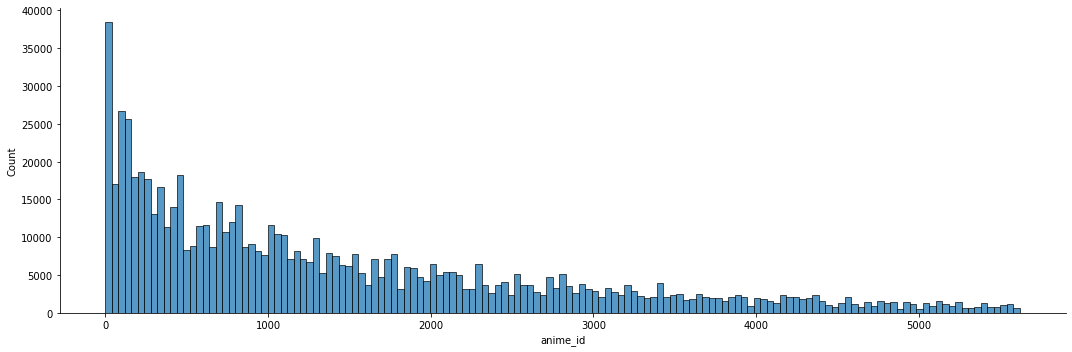

In [89]:
sns.displot(x='anime_id', data=ratings, aspect=3)

* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"

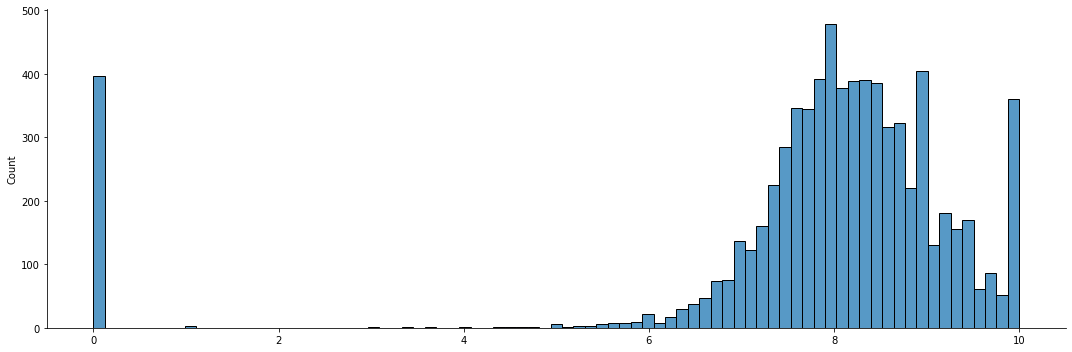

In [91]:
avg_rating = np.zeros(USERS_NUM)
for i, x in enumerate(X):
    val = x[x>0]
    if (len(val) != 0):
        avg_rating[i] = np.mean(val)

sns.displot(avg_rating, aspect=3) # средний рейтинг среди пользователей в выборке

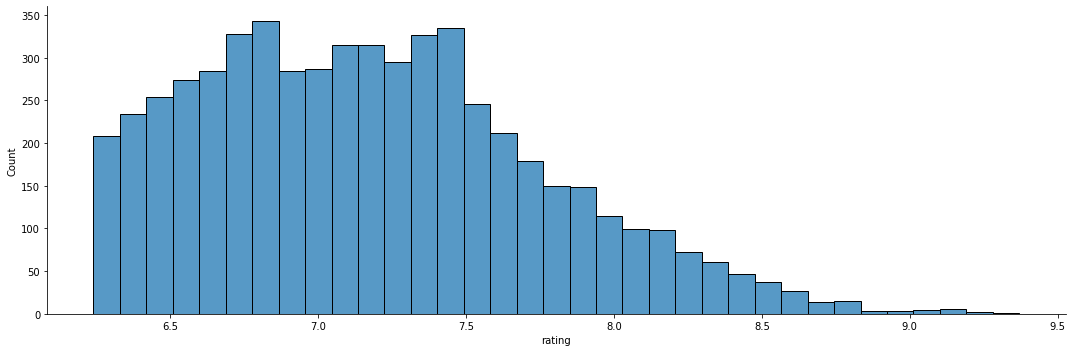

In [92]:
sns.displot(x='rating', data=anime, aspect=3) # средний рейтинг по аниме в выборке

* и т.д. (бонус)

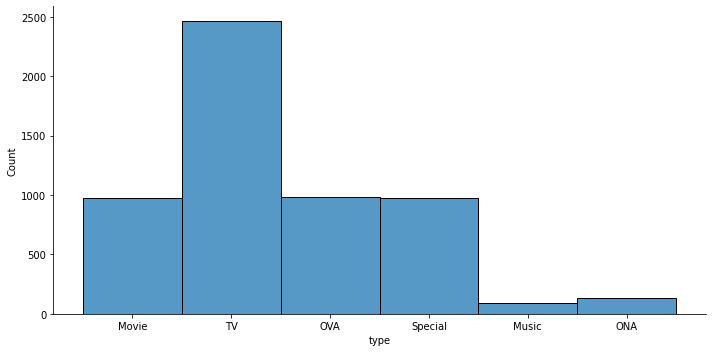

In [93]:
sns.displot(x='type', data=anime, aspect=2)

### Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)

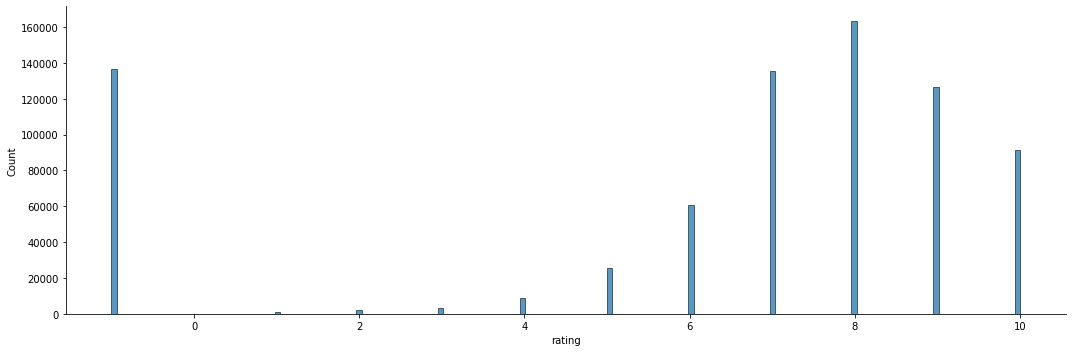

In [94]:
sns.displot(x='rating', data=ratings, aspect=3)

### Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

Будет сделано в 5-ом задании

### Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

In [125]:
def solve_most_popular1(user_id: int, result_size: int = 5):
    df = anime[['anime_id', 'rating', 'members']].copy()
    df.sort_values(by=['rating', 'members'], ascending=[False, False])
    return df.head(result_size)['anime_id'].values

In [126]:
def solve_most_popular2(user_id: int, result_size: int = 5):
    return ratings.groupby('anime_id', as_index=False).mean().sort_values(by='rating', ascending=False).head(result_size)['anime_id'].values

In [127]:
# just give a few most popular anime_ids by rating
print(solve_most_popular1(131))
print(solve_most_popular2(123))

[0 1 2 3 4]
[3527 2921 4467 3008 4536]


### Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

In [38]:
U, D, V = np.linalg.svd(X, full_matrices=False)

In [39]:
k = 10

U = U[:, :k].astype(np.float32)
D = np.diag(D)[:k, :k].astype(np.float32)
V = V[:k, :].astype(np.float32)

In [128]:
def solve_collaborative_filter(user_id: int, result_size: int = 5):
    usr_factor = U[user_id]
    result = {i: usr_factor.dot(f) for i, f in enumerate(V.T)}
    return [k for k, _ in sorted(result.items(), key=lambda item: item[1], reverse=True)][:result_size]

In [131]:
print(solve_collaborative_filter(612))
print(solve_collaborative_filter(4211))
print(solve_collaborative_filter(241))

[19, 13, 39, 738, 1664]
[3, 10, 82, 154, 217]
[39, 82, 432, 782, 738]


### Задание №6 Решить задачу на основе контент-based подхода, выбрав один из методов решения (2 балла):

In [40]:
def encode(s: str, pad_size: int, word_to_num: dict[str, int], pad_sym, unk_sym):
    encoded = [word_to_num.get(tok, unk_sym) for tok in str.split(s, ' ')]

    if len(encoded) >= pad_size:
        return encoded[:pad_size]
    encoded.extend([pad_sym] * (pad_size - len(encoded)))
    return encoded

In [43]:
class AnimeDataset(Dataset):
    # token threshold
    MIN_COUNT = 10

    # special tokens for unknown and empty words
    PAD, UNK = 'PAD', 'UNK'
    PAD_IX, UNK_IX = 0, 1

    TEXT_COLS = ['name', 'genre']
    CATEGORIAL_COLS = ['type']
    NUMERIC_COLS = ['episodes', 'rating', 'members']

    TEXT_MAX_SIZE = 20 # for padding

    def _process_anime(self):
        # fill missing values
        self._anime[self.CATEGORIAL_COLS] = self._anime[self.CATEGORIAL_COLS].fillna('NaN')
        self._anime[self.TEXT_COLS] = self._anime[self.TEXT_COLS].fillna('NaN')
        self._anime[self.NUMERIC_COLS] = self._anime[self.NUMERIC_COLS].fillna(0)
        self._anime[self.NUMERIC_COLS] = self._anime[self.NUMERIC_COLS].replace('Unknown', 0)

        # scale numeric data
        self._anime[self.NUMERIC_COLS] = MinMaxScaler().fit_transform(self._anime[self.NUMERIC_COLS])

        # convert text fields to space-separated string of tokens
        tokenizer = nltk.tokenize.WordPunctTokenizer()
        self._anime[self.TEXT_COLS] = self._anime[self.TEXT_COLS].applymap(lambda x: ' '.join(tokenizer.tokenize(x.lower())))

        # count how many times does each token occur in both "Title" and "FullDescription" in total
        tok_cntr = Counter()
        for col in self._anime[self.TEXT_COLS]:
            for line in self._anime[col].values:
                tok_cntr.update(line.split(' '))

        # get a list of all tokens that occur at least MIN_COUNT times
        self._tokens = sorted(t for t, c in tok_cntr.items() if c >= self.MIN_COUNT)

        # add a special tokens for unknown and empty words
        self._tokens = [self.PAD, self.UNK] + self._tokens

        # build an inverse token index: a dictionary from token(string) to it's index in tokens(int)
        self._token_to_id = {t: i for i, t in enumerate(self._tokens)}

        # encode the categorical data we have
        cat_vectorizer = DictVectorizer(dtype=np.float32, sparse=False).fit(self._anime[self.CATEGORIAL_COLS].apply(dict, axis=1))
        self._categorical = cat_vectorizer.transform(self._anime[self.CATEGORIAL_COLS].apply(dict, axis=1))

        # numerical preprocessing
        self._numerical = np.zeros((ANIME_NUM, len(self.NUMERIC_COLS)))
        num = self._anime[self.NUMERIC_COLS].values
        for i in range(len(num)):
            self._numerical[self._anime.iloc[i]['anime_id']] = num[i]

    def __init__(self, U, V, anime: pd.DataFrame, ratings: pd.DataFrame):
        self._anime = anime
        self._ratings = ratings
        self._U = U
        self._V = V.T
        self._process_anime()

    def __getitem__(self, i):
        user_id = self._ratings.values[i][0] - 1
        anime_id = self._ratings.values[i][1]
        target = self._ratings.values[i][2]

        row = self._anime.values[anime_id]

        return (
            [
                torch.tensor(self._U[user_id], dtype=torch.float32),
                torch.tensor(self._V[anime_id], dtype=torch.float32),
                torch.tensor(encode(row[1], self.TEXT_MAX_SIZE, self._token_to_id, self.PAD_IX, self.UNK_IX), dtype=torch.int32),
                torch.tensor(encode(row[2], self.TEXT_MAX_SIZE, self._token_to_id, self.PAD_IX, self.UNK_IX), dtype=torch.int32),
                torch.tensor(self._categorical[anime_id], dtype=torch.float32),
                torch.tensor(self._numerical[anime_id], dtype=torch.float32)
            ],
            [
                torch.tensor([target], dtype=torch.float32)
            ]
        )
        
    def __len__(self):
        return len(self._ratings)

In [44]:
dataset = AnimeDataset(U, V, anime.copy(), ratings.copy())

In [45]:
train_size = round(len(dataset) * 0.70) # 70% for train
val_size = round((len(dataset) - train_size) * (1/3)) # 10% for validation
test_size = (len(dataset) - train_size) - val_size # 20% for test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [46]:
train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    
    def __init__(self, emb_size=16, voc_size=len(dataset._tokens), k=10, linear_size=32):
        super().__init__()
        self.k = k
        self.emb_size = emb_size
        self.voc_size = voc_size
        self.linear_size = linear_size
        
        self.U_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.V_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.U_V_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.Embedder = nn.Embedding(voc_size, emb_size)
        
        self.N_encoder = nn.Sequential(
            nn.LazyConv1d(linear_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=linear_size // 2),
            nn.Flatten(start_dim=1),
        )
        
        self.G_encoder = nn.Sequential(
            nn.LazyConv1d(linear_size, kernel_size=2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=linear_size // 2),
            nn.Flatten(start_dim=1),
        )
        
        self.C_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.N2_linear = nn.Sequential(
            nn.LazyLinear(linear_size),
            nn.ReLU(),
        )
        
        self.Filter = nn.Sequential(
            nn.LazyLinear(linear_size * 8),
            nn.ReLU(),
            nn.LazyLinear(linear_size * 4),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
        
    def forward(self, batch):
        U = batch[0]
        V = batch[1]
        N = batch[2]
        G = batch[3]
        C = batch[4]
        N2 = batch[5]

        U_features = self.U_linear(U)
        V_features = self.V_linear(V)
        UV_features = torch.cat([U_features, V_features], dim=1)
        UV_features = self.U_V_linear(UV_features)
        
        N_emb = self.Embedder(N).permute(0, 2, 1)
        G_emb = self.Embedder(G).permute(0, 2, 1)
        
        N_features = self.N_encoder(N_emb)
        G_features = self.G_encoder(G_emb)
        
        C_features = self.C_linear(C)
        N2_features = self.N2_linear(N2)
        
        features = torch.cat(
            [UV_features,
            N_features,
            G_features,
            C_features,
            N2_features,], dim=1
        )
        
        prediction = self.Filter(features)
        
        return prediction

In [48]:
def evaluate(model, device=None):
    squared_error = abs_error = num_samples = 0.0

    loader = val_loader if not device else DeviceDataLoader(val_loader, device)

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            squared_error += torch.mean(torch.square(pred - y[0]))
            abs_error += torch.mean(torch.abs(pred - y[0]))
            num_samples += len(x)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    return mse, mae

In [49]:
def train(model, optimizer, epoches=5, device=None, criterion=nn.MSELoss(reduction='mean')):
    loader = train_loader

    if device:
        model.to(device)
        loader = DeviceDataLoader(train_loader, device)

    for epoch in range(epoches):
        model.train()
        for x, y in tqdm(loader):
            optimizer.zero_grad(set_to_none=True)
            pred = model(x)
            loss = criterion(pred, y[0])
            loss.backward()
            optimizer.step()

        mse, mae = evaluate(model, device)
        print(f'Epoch: {epoch+1} | Loss: {loss.item()} | Validation: MSE={mse}/MAE={mae}')

    if device:
        model.cpu()

In [50]:
def test(model, device=None):
    squared_error = abs_error = num_samples = 0.0
    loader = test_loader

    if device:
        model.to(device)
        loader = DeviceDataLoader(test_loader, device)

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            squared_error += torch.mean(torch.square(pred - y[0]))
            abs_error += torch.mean(torch.abs(pred - y[0]))
            num_samples += len(x)

    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    if device:
        model.cpu()

    return mse, mae

In [53]:
model = NeuralNetwork()

train(model, torch.optim.Adam(model.parameters(), lr=1e-2), epoches=5)

100%|██████████| 4129/4129 [05:57<00:00, 11.53it/s]


Epoch: 1 | Loss: 8.142965316772461 | Validation: MSE=1.131210896120233/MAE=0.27541357352908724


100%|██████████| 4129/4129 [06:00<00:00, 11.46it/s]


Epoch: 2 | Loss: 8.084618377685547 | Validation: MSE=1.051880986272952/MAE=0.2732898604398393


100%|██████████| 4129/4129 [06:01<00:00, 11.41it/s]


Epoch: 3 | Loss: 8.039725494384766 | Validation: MSE=1.0313910360390184/MAE=0.2695738366768185


100%|██████████| 4129/4129 [06:02<00:00, 11.41it/s]


Epoch: 4 | Loss: 8.027344207763672 | Validation: MSE=1.0129756604210804/MAE=0.27028760317355227


100%|██████████| 4129/4129 [05:58<00:00, 11.51it/s]


Epoch: 5 | Loss: 7.999155578613281 | Validation: MSE=0.9889555333024365/MAE=0.26083432644774013


### Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):


In [168]:
from sklearn.metrics import ndcg_score


# content-based
scores = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        pred = model(x)
        scores.append(ndcg_score([y[0].flatten().numpy()], [pred.flatten().numpy()]))

print(f'Avg. NDCG score with content-based method: {np.mean(scores)}')

Avg. NDCG score with content-based method: 0.9626242015750491


In [167]:
# collaborative filters
scores = []
usr = 1497

res = solve_collaborative_filter(usr, result_size=10)
true = np.flip(np.argsort(X[usr]))[:10] # pick 10 most liked animes

print(f'NDCG score with collaborative filter method: {ndcg_score([true], [res])}')

NDCG score with collaborative filter method: 0.9780821092037092
